# ca1 : الگوریتم ژنتیک
#### mahdi vajhi
#### 810101558
<p dir=rtl style="text-align:right">
هدف از این پروژه حل مسئله 
Problem Knapsack
با استفاده از الگوریتم ژنتیک است. ما در این مسئله باید حالت بهینه از غذا ها را که شرایط ورودی را داشته باشد پیدا کنیم.
برای این کار ما ابتدا باید ساختار کروموزوم های خود را تعریف کنیم که دارای قابلیت تلفیق با بقیه و جهش را داشته باشد. سپس باید تعدادی کروموزوم اولیه تولید کنیم و با پیاده سازی یک تابع فیتنس برای آنها میزان خوب بودن آنها را بسنجیم این تابع باید به شرایط مسئله حساس باشد و همچنین میزان خوب بودن ژن ها را نشان دهد. سپس باید تابعی برای تولید نسل بعدی نوشت که ابتدا کروموزوم ها را جفت کند سپس آنها را تلفیق کند و در نهایت آنها را جهش دهد. در آخر هم باید نتایج را بررسی کرد و جواب به دست آمده را بررسی کنیم.
</p>

## initial block

<p dir=rtl>
ثابت های زیر مقدار اولیه هستند و در آخر مقادیر متفاوت نیز آزمایش شده
</p>

In [135]:
import random
import pandas as pd
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import time
import json


CHROMOSOME_COUNT_RATE = 0.5
WIGHT_MUTATION_RATE = 0.05
MIN_WEIGHT = 0.5
IS_WIGHT_MUTATION_IF_DEACTIVATE = True
FIRST_GENERATION_COUNT = 10
CROSSOVER_CHANCE = 1/3
SWAP_CHANCE_IN_CROSSOVER = 1/5
POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
HAVE_CROSSOVER = True
HAVE_MUTATION = True
GENERATION_STEP = 1000
INCREASE_GENERATION_RATE = 1
OLD_CHORMO_COUNT = 5
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.1
PRINT_RATE = 5
PRINT_ACTIVE = True

## تعریف کروموزوم و ژن ها
<p dir=rtl>
در این مسئله با توجه به این که طول کروموزوم باید ثابت باشد و همچنین تعداد غذا ها ثابت است می توانیم کروموزوم را فهرست تمام غذا ها بگذاریم که با یک متغییر مشخص شود که آیا آن غذا را می بریم یا خیر و اگر می بریم چه مقدار از آن را می بریم. پس در این مسئله ژن ها همان غذا ها هستند که می تواند فعال یا غیر فعال باشند.
</p>

### ژن ها
<p dir=rtl>
کلاس ژن در واقع نماینده یک غذا است که در آن نام، حداکثر مقدار موجود، فعال بودن آن، چگالی ارزش آن و وزن الان آن است.
</p>
<p dir=rtl>
در تابع جهش ژن با احتمالی که تعیین شده می تواند فعال یا غیر فعال شود
همچنین وزن آن با یک توزیع نرمال حول مقدار قبلی خود تغییر می کند. توزیع به گونه ای تنظیم شده که انحراف معیار به اندازه یک ثابت بین ۰ تا ۱ در مقدار وزن باشد که تغییر معقول باشد. همچنین شرطی گذاشته شده که آیا درموقع غیر فعال بودن ژن وزن آن جهش کند یا خیر
</p>


In [2]:
class Gen:
    def __init__(self, name:str, max_weight:float, value_per_weight:float
                 , weight:float=1, is_active:bool=False):
        self.name = name
        self.max_weight = max_weight
        self.vpw = value_per_weight
        self.is_active = is_active
        self.weight = weight

    def set_random_gen(self):
        self.weight = random.uniform(MIN_WEIGHT, self.max_weight)

    def set_gen_weight(self, new_weight):
        self.weight = new_weight
    def set_gen_status(self, status:bool):
        self.is_active = status

    def mutation(self):
        if IS_WIGHT_MUTATION_IF_DEACTIVATE or self.is_active:
            if WIGHT_MUTATION_CHANCE > random.random():
                self.weight = max(MIN_WEIGHT,
                                  min(self.max_weight, self.weight 
                                      + (self.max_weight * WIGHT_MUTATION_RATE 
                                         * random.choice([1,-1]))))
        
        
    # Getters
    def get_weight(self):
        return self.weight if self.is_active else 0
    def get_value(self):
        return self.weight * self.vpw if self.is_active else 0
    def get_name(self):
        return self.name
    def get_is_active(self):
        return self.is_active
    def __str__(self):
        return "------------\n" +\
                f"name: {self.name}\n"+\
                f"status: {self.is_active}\n" +\
                f"weight: {self.weight:.2f}\n"+\
                f"max weight: {self.max_weight:.2f}\n"+\
                f"vpw: {self.vpw:.2f}\n"+\
                f"value: {self.vpw * self.weight:.2f}"
    def __repr__(self):
        return self.__str__()

### کروموزوم ها
<p dir=rtl>
کلاس کروموزوم صرفا اجماع ژن ها است و توابع آن صرفا روی ژن ها حلقه می زند.
</p>
<p dir=rtl>
فقط تابع تلفیق ژن ها اضافه شده. برای این کار اپراتور جمع بازنویسی شده و با یک احتمالی کروموزوم ها را تلفیق می کند ویا همان ها را بر می گرداند. برای تقاطع دادن آن ها از تقاطع با احتمال یکسان استفاده شده چون توالی غذا ها مفهوم خاصی ندارد و دلیلی ندارد به خاطر متوالی بودن دو غذا احتمال تقاطع آنها وابسته به هم باشد. در آخر با یک swap کردن دو کروموزوم جدید را ساختیم.
</p>

In [3]:
class Chromosome:
    def __init__(self, gens:list[Gen], count_range:list[int]):
        self.gens = gens
        self.count_range = count_range

    def mutation(self):
        self.weight_mutation()
        self.count_mutation()
    def count_mutation(self):
        if random.random() > CHROMOSOME_MUTATION_RATE:
            return
        self.add_or_remove_food_mutation()
        self.change_active_food_mutation()
            
    def change_active_food_mutation(self):
        disable_gen = [i for i in range(len(self.gens)) if self.gens[i].is_active == False]
        active_gen = [i for i in range(len(self.gens)) if self.gens[i].is_active == True]
        change_count = np.random.randint(min(len(active_gen), len(disable_gen)) + 1)
        selected_disable_gen = np.random.choice(disable_gen, change_count, replace=False)
        selected_active_gen = np.random.choice(active_gen, change_count, replace=False)
        for i, j in zip(selected_disable_gen, selected_active_gen):
            self.gens[i].set_gen_status(True)
            self.gens[j].set_gen_status(False)
        
    def add_or_remove_food_mutation(self):
        new_count = np.random.randint(self.count_range[0], self.count_range[1] + 1)
        diff = new_count - len([i for i in range(len(self.gens)) if self.gens[i].is_active == True])
        if diff == 0:
            return
        elif diff > 0:
            disable_food = np.random.choice([i for i in range(len(self.gens)) if self.gens[i].is_active == False], int(diff), replace=False)
            for i in disable_food:
                self.gens[i].set_gen_status(True)
        else:
            active_food = np.random.choice([i for i in range(len(self.gens)) if self.gens[i].is_active == True], int(abs(diff)), replace=False)
            for i in active_food:
                self.gens[i].set_gen_status(False)

    def weight_mutation(self):
        for i in self.gens:
            i.mutation()
    
    # Uniform crossover
    def __add__(self, pair):
        if random.choices([True, False],
                          [CROSSOVER_CHANCE,1 - CROSSOVER_CHANCE])[0]:
            return self.crossover(pair)
        return self, pair
    
    def crossover(self, pair):
        all_active_gen, count = self.get_active_gen_and_number(pair)
        child_1 = self.create_gens_for_new_chromosome(all_active_gen, count, pair)
        child_2 = self.create_gens_for_new_chromosome(all_active_gen, count, pair)
        
        return Chromosome(child_1, self.count_range), Chromosome(child_2, self.count_range)
            
 
        
    def get_active_gen_and_number(self, pair) -> tuple[dict[int, list[int]], list[int]]:
        counter = [0, 0]
        active_gen = dict[int, list[int]]()
        chromosomes = [self, pair]
        for i in range(len(chromosomes)):
            for j in range(len(self.gens)):
                if chromosomes[i].gens[j].is_active == True:
                    counter[i] += 1
                    if j in active_gen:
                        active_gen[j] += [i]
                    else:
                        active_gen[j] = [i]

        return active_gen, counter
                
    
    def create_gens_from_pair(self, pair) -> list[Gen]:
        new_gen = Gen
        new_gens = list[Gen]()
        for i in range(len(self.gens)):
            if np.random.randint(2):
                new_gen = copy.deepcopy(self.gens[i])
            else:
                new_gen = copy.deepcopy(pair.gens[i])
            new_gen.set_gen_status(False)
            new_gens.append(new_gen)
        return new_gens
    
    def get_swap_gen_status(self):
        return random.choices([True, False],
            [SWAP_CHANCE_IN_CROSSOVER, 1 - SWAP_CHANCE_IN_CROSSOVER],
            k=len(self.gens))
        
    # Getters
    def get_weight(self):
        return sum([i.get_weight() for i in self.gens])
    def get_value(self):
        return sum([i.get_value() for i in self.gens])
    def get_vpw(self):
        if self.get_weight() == 0:
            return 0
        return self.get_value() / self.get_weight()
    def get_name(self):
        return [i.get_name() for i in self.gens]
    def get_active_count(self):
        return sum([i.get_is_active() for i in self.gens])
    
    def __str__(self):
        return "__________\n"+\
                f"active_count: {self.get_active_count()}\n"+\
                f"weight: {self.get_weight():.2f}\n"+\
                f"value: {self.get_value():.2f}\n"+\
                f"vpw: {self.get_vpw():.2f}"
    def __repr__(self):
        return self.__str__()
    
    def __lt__(self, x):
        return calculate_fitness(self, conditions) > calculate_fitness(x,conditions)
    def __gt__(self, x):
        return calculate_fitness(self, conditions) < calculate_fitness(x,conditions)

## تولید جمعیت اولیه
<p dir=rtl>
در این قسمت باید جامعه اولیه را تولید کنیم که شامل مراجل زیر است:
</p>
<ol dir=rtl>
    <li> خواندن داده ها </li>
    <li> تولید ژن خام از غذا ها </li>
    <li> تولید کرموزوم ها با ژن های خام و مقدار دهی شانسی وزن آنها و وضعیت شانسی فعال بودن ژن ها </li>
</ol>

### read data
<p dir=rtl style="text-align:right">
در این قسمت فایل
snacks.csv
را لود می کنیم که داده های غذا های مربوط به پروژه در آن قرار دارد
</p>

In [4]:
snacks = pd.read_csv('./snacks.csv')
snacks

,Snack,Available Weight,Value
0,MazMaz,10,10
1,Doogh-e-Abali,15,10
2,Nani,5,5
3,Jooj,7,15
4,Hot-Dog,20,15
5,Chips,8,6
6,Nooshaba,12,8
7,Shokolat,6,7
8,Chocoroll,9,12
9,Cookies,11,11


### ساخت ژن های خام
<p dir=rtl>
در این قسمت داده های جدول را باید به ژن ها تبدیل کنیم اما مقدار وزن و فعال بودن آن در کروموزوم تعیین می شود
</p>

In [5]:
row_gens = list[Gen]()
for i in snacks.iterrows():
    name, max_weight, value = i[1]
    row_gens.append(Gen(name, max_weight, value/max_weight))

In [6]:
for i in row_gens[:2]:
    print(i)

------------
name: MazMaz
status: False
weight: 1.00
max weight: 10.00
vpw: 1.00
value: 1.00
------------
name: Doogh-e-Abali
status: False
weight: 1.00
max weight: 15.00
vpw: 0.67
value: 0.67


### ساخت کروموزوم های اولیه
<p dir=rtl>
در این قسمت ژن ها را برای هر کروموزوم مقدار شانسی می دهیم و کروموزوم های اولیه را می سازیم. برای تعداد جمعیت پارامتر هایی تعریف می کنیم.
</p>

<p dir=rtl>
تابع زیر با استفاده از ژن های خام یک کروموزوم رندوم می سازد
</p>

In [7]:
def create_random_chromosome(count_range) -> Chromosome:
    gens = list[Gen]()
    for i in row_gens:
        new_gen = copy.deepcopy(i)
        new_gen.set_random_gen()
        gens.append(new_gen)
    active_count = np.random.randint(count_range[0],count_range[1]+1)
    for i in np.random.choice([i for i in range(len(gens))], active_count, replace=False):
        gens[i].set_gen_status(True)
    return Chromosome(gens,count_range)

<p dir=rtl>
تابع زیر با کمک تابع قبل کروموزوم های اولیه را می سازد
</p>

In [8]:
def create_first_generation(count_range) -> list[Chromosome]:
    first_chromosomes = list[Chromosome]()
    for _ in range(FIRST_GENERATION_COUNT):
        first_chromosomes.append(create_random_chromosome(count_range))
    return first_chromosomes

<p dir=rtl>
کارکرد آن را بررسی می کنیم
</p>

In [108]:
FIRST_GENERATION_COUNT = 2
test = create_first_generation([2,4])
for i in test[:2]:
    print(r'###############')
    print(i)
    print(r'__________')
    for j in i.gens[:1]:
        print(j)

###############
__________
active_count: 2
weight: 10.99
value: 7.71
vpw: 0.70
__________
------------
name: MazMaz
status: False
weight: 3.42
max weight: 10.00
vpw: 1.00
value: 3.42
###############
__________
active_count: 3
weight: 9.39
value: 11.02
vpw: 1.17
__________
------------
name: MazMaz
status: False
weight: 0.89
max weight: 10.00
vpw: 1.00
value: 0.89


## ساخت تابع فیتنس
<p dir=rtl>
برای طراحی تابع فیتنس باید موارد زیر را در نظر بگیریم:
</p>
<ul dir=rtl>
    <li> بیشتر بودن ارزش غذایی از ورودی مسئله </li>
    <li> کمتر بودن وزن از ورودی مسئله </li>
    <li> قرار گرفتن تعداد غذا ها در بازه ورودی مسئله </li>
</ul>
<p dir=rtl>
چون حداکثر وزن هر خوراکی در ژن ها اعمال شده ژن ها از آن عبور نمی کنند بنابراین نیازی به لحاظ کردن آن نیست.
</p>
<p dir=rtl>
موارد زیر را می توان نکات مثبت برای کرموزوم در نظر گرفت:
</p>
<ul dir=rtl>
    <li> بالا بودن vpw </li>
    <li> بالا بودن ارزش </li>
</ul>

In [10]:
def calculate_value_fitness(value:float, condition:float):
    diff = value - condition
    if diff < 0:
        return diff
    return diff * POSITIVE_VALUE_RATE

def calculate_weight_fitness(weight:float, condition:float):
    diff = condition - weight
    if diff < 0:
        return diff
    return diff * POSITIVE_WEIGHT_RATE

def calculate_count_fitness(count:int, condition:list[int]):
    if count < condition[0]:
        return count - condition[0]
    if count > condition[1]:
        return condition[1] - count
    else:
        return POSITIVE_COUNT_RATE

In [11]:
def calculate_fitness(chromosome:Chromosome, conditions:dict):
    value_point =   calculate_value_fitness(chromosome.get_value(), conditions["value"])
    weight_point =  calculate_weight_fitness(chromosome.get_weight(), conditions["weight"])
    count_point =   calculate_count_fitness(chromosome.get_active_count(), conditions["count"])
    return  value_point  *  FITNESS_VALUE_RATE +\
            weight_point *  FITNESS_WEIGHT_RATE +\
            count_point  *  FITNESS_COUNT_RATE 

In [12]:
def calculate_generation_fitness(generation:list[Chromosome], conditions):
    fitness = list[float]()
    for i in generation:
        fitness.append(calculate_fitness(i, conditions))
    return fitness

## تولید نسل بعدی
<p dir=rtl>
تابع جهش و تلفیق در کلاس ها نوشته شده در این بخش با استفاده از آنها و تابع فیتنس نسل بعد را تولید می کنیم.
</p>

<p dir=rtl>
مراحل تابع تولید نسل به صورت زیر است:
</p>
<ol dir=rtl>
    <li> تبدیل فیتنس ها به احتمال </li>
    <li> جفت کردن کروموزوم ها با در نظر گرفتن احتمال </li>
    <li> تولید کروموزوم های جدید با تلفیق جفت ها </li>
    <li> جهش کروموزوم ها </li>
    <li> افزودن کروموزوم ها به نسل جدید </li>
</ol>

<p dir=rtl>
تابع زیر جهت تبدیل فیتنس به احتمال انتخاب است. به این صورت که کوچکترین عدد را اگر از ۱ کوچک تر است همه اعداد را طوری جمع می زند که آن عدد ۱ شود و سپس احتمال را برابر نسبت فیتنس به جمع کل فیتنس ها قرار می دهد
</p>

In [13]:
def convert_fitness_to_probability_of_choice(generation_fitness:list[float]):
    minimum = min(generation_fitness)
    if minimum <= 0:
        generation_fitness = [i + abs(minimum) + 1 for i in generation_fitness]
    sum_all = sum(generation_fitness)
    return [i/sum_all for i in generation_fitness]

In [14]:
def create_children(pair:tuple[Chromosome, Chromosome]) -> tuple[Chromosome, Chromosome]:
    children = tuple[Chromosome, Chromosome]()
    
    if HAVE_CROSSOVER:
        children = pair[0] + pair[1]
    else:
        children = copy.deepcopy(pair)
    
    if HAVE_MUTATION:
        for i in children:
            i.mutation()
    
    return children

In [15]:
def create_next_generation(generation:list[Chromosome], generation_fitness:list[float],
                           size:int) -> list[Chromosome]:
    probability_of_choice = convert_fitness_to_probability_of_choice(generation_fitness)
    rand_choice = np.random.choice(generation, size, p=probability_of_choice)
    next_generation = list[Chromosome]()
    for i in range(math.floor(size/2)):
        children = create_children((rand_choice[i*2], rand_choice[i*2+1]))
        next_generation.extend(children)
    
    return next_generation

## ایجاد الگوریتم ژنتیک
<p dir=rtl>
در آخر باید الگوریتم ژنتیک را پیاده کنیم که مراحل زیر را دارد:
</p>
<ol dir=rtl>
    <li> تولید نسل اول </li>
    <li>  تولید نسل های بعدی و محاسبه فیتنس آنها </li>
    <li> نمایش بهترین های نسل آخر به عنوان جواب </li>
</ol>

In [16]:
def check_chromosome(chromosome:Chromosome, conditions):
    return calculate_value_fitness(chromosome.get_value(), conditions["value"]) >= 0 and\
           calculate_weight_fitness(chromosome.get_weight(), conditions["weight"]) >= 0 and\
           calculate_count_fitness(chromosome.get_active_count(), conditions["count"]) >= 0
def get_generation_size(step:int):
    return int(round(step * INCREASE_GENERATION_RATE * FIRST_GENERATION_COUNT + FIRST_GENERATION_COUNT))
def find_best_chromosome(generation:list[Chromosome], generation_fitness:list[float]):
    return generation[np.argmax(generation_fitness)]

In [ ]:
def solve_with_genetic(conditions):
    generation = create_first_generation(conditions["count"])
    generation_fitness = calculate_generation_fitness(generation, conditions)
    
    for i in range(GENERATION_STEP):
        generation = create_next_generation(generation, generation_fitness, get_generation_size(i))
        
        generation_fitness = calculate_generation_fitness(generation, conditions)
        
        best_chromosome = find_best_chromosome(generation, generation_fitness)
        
        if check_chromosome(best_chromosome, conditions):
            return best_chromosome, i
    raise Exception("doesn't find")

In [120]:
def solve_with_genetic(conditions):
    best_chromosome = Chromosome
    generation = create_first_generation(conditions["count"])
    generation_fitness = calculate_generation_fitness(generation, conditions)
    for i in range(GENERATION_STEP):
        generation = create_next_generation(generation, generation_fitness
                                            , get_generation_size(i))
        generation_fitness = calculate_generation_fitness(generation, conditions)
        best_chromosome = find_best_chromosome(generation, generation_fitness)
        if PRINT_ACTIVE and i%PRINT_RATE == 0:
            print(f"step {i}, best:{calculate_fitness(best_chromosome, conditions):.2f}, avg:{np.average([calculate_fitness(i, conditions) for i in generation]):.2f}, size:{len(generation)}")
            # print(i, calculate_fitness(best_chromosome, conditions), np.average([calculate_fitness(i, conditions) for i in generation]), len(generation))
        if check_chromosome(best_chromosome, conditions):
            if PRINT_ACTIVE:
                print(f"step {i}, best:{calculate_fitness(best_chromosome, conditions):.2f}, avg:{np.average([calculate_fitness(i, conditions) for i in generation]):.2f}, size:{len(generation)}")
                # print(calculate_fitness(best_chromosome, conditions), np.average([calculate_fitness(i, conditions) for i in generation]))
            return best_chromosome, i
    raise Exception("doesn't find")

## بررسی نتایج

<p dir=rtl>
ابتدا با یک تنظیم اولیه آزمایش می کنیم و می بینیم که میانگین تغییری نمی کند ولی به جواب می رسیم
</p>

In [198]:
conditions = {"weight": 10,
              "value": 21,
              "count": [3,19]}
conditions = {"weight": 10,
              "value": 12,
              "count": [2,4]}

# Generation parameter
FIRST_GENERATION_COUNT = 20
GENERATION_STEP = 100000
INCREASE_GENERATION_RATE = 0
PRINT_RATE = 100

# Enable feature
PRINT_ACTIVE = False
HAVE_CROSSOVER = True
HAVE_MUTATION = True

# Feature rate
WIGHT_MUTATION_RATE = 0.2
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.3
CROSSOVER_CHANCE = 1/3

MIN_WEIGHT = 0.5
IS_WIGHT_MUTATION_IF_DEACTIVATE = True
SWAP_CHANCE_IN_CROSSOVER = 1/5
POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1

best_chromosome, step = solve_with_genetic(conditions)
# for i in best_chromosome.gens:
#     if i.get_is_active():
#         print(i)
print(best_chromosome)
print(f"-------\nstep: {step}")
print(f"size: {FIRST_GENERATION_COUNT}")

__________
active_count: 3
weight: 8.86
value: 12.82
vpw: 1.45
-------
step: 0
size: 20


In [190]:
def get_average_time(count, conditions):
    time_list = list()
    for _ in range(count):
        start_time = time.time()
        solve_with_genetic(conditions)
        time_list.append(time.time() - start_time)
    return np.average(time_list)
get_average_time(5, conditions)

0.4086128234863281

In [54]:
def test_parameter(conditions, parameter_range, step, run_count):
    global FIRST_GENERATION_COUNT
    timer = dict()
    for i in range(parameter_range[0], parameter_range[1], round((parameter_range[1] - parameter_range[0]) / step)):
        FIRST_GENERATION_COUNT = i
        timer[FIRST_GENERATION_COUNT] = get_average_time(run_count, conditions)
        print(f"{i}: {timer[FIRST_GENERATION_COUNT]:.4f}")
    return timer

In [ ]:
conditions = {"weight": 10,
              "value": 12,
              "count": [2,4]}
parameter_range = [5, 50]
step = 40
run_count = 10
timer = test_parameter(conditions, parameter_range, step, run_count)
json_data = json.dumps(timer, indent=4)
file_path = f"data_{parameter_range[0]}_{parameter_range[1]}_{random.randint(1, 1000)}.json"
with open(file_path, "w") as file:
    file.write(json_data)
print(f"Data has been saved to {file_path}")

<BarContainer object of 598 artists>

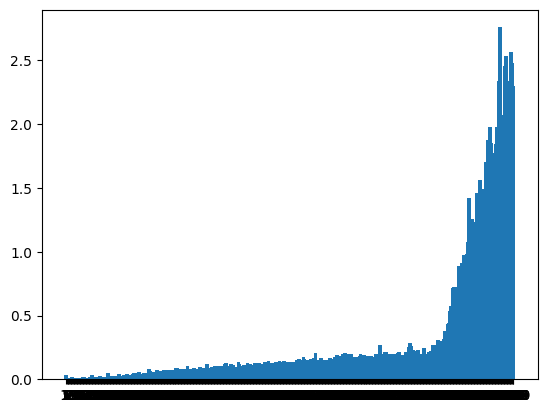

In [145]:
timer = dict()
with open('./data_5_10000.json') as file:
    timer = json.load(file)
plt.bar(list(timer.keys()), timer.values(),width=5)

## Change parameter

### mutation

In [207]:
conditions = {"weight": 10,
              "value": 21,
              "count": [3,19]}

# Generation parameter
FIRST_GENERATION_COUNT = 20
GENERATION_STEP = 100000
INCREASE_GENERATION_RATE = 0
PRINT_RATE = 100

# Enable feature
PRINT_ACTIVE = False
HAVE_CROSSOVER = True
HAVE_MUTATION = True

# Feature rate
WIGHT_MUTATION_RATE = 0.2
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.3
CROSSOVER_CHANCE = 1/3
get_average_time(5, conditions)

2.086403322219849

In [211]:
# Feature rate
WIGHT_MUTATION_RATE = 0.1
CHROMOSOME_MUTATION_RATE = 0.02
WIGHT_MUTATION_CHANCE = 0.1
CROSSOVER_CHANCE = 1/3
get_average_time(5, conditions)

3.544425630569458

In [215]:
# Feature rate
WIGHT_MUTATION_RATE = 0.5
CHROMOSOME_MUTATION_RATE = 0.4
WIGHT_MUTATION_CHANCE = 0.6
CROSSOVER_CHANCE = 1/3
# get_average_time(1, conditions)

KeyboardInterrupt: 

### cross

In [218]:
conditions = {"weight": 10,
              "value": 21,
              "count": [3,19]}

# Generation parameter
FIRST_GENERATION_COUNT = 20
GENERATION_STEP = 100000
INCREASE_GENERATION_RATE = 0
PRINT_RATE = 100

# Enable feature
PRINT_ACTIVE = False
HAVE_CROSSOVER = True
HAVE_MUTATION = True

# Feature rate
WIGHT_MUTATION_RATE = 0.2
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.3
CROSSOVER_CHANCE = 1/3
get_average_time(5, conditions)

1.7758838176727294

In [223]:
CROSSOVER_CHANCE = 1/2
get_average_time(5, conditions)

2.080276107788086

In [221]:
CROSSOVER_CHANCE = 1
get_average_time(5, conditions)

6.7754968166351315

In [222]:
CROSSOVER_CHANCE = 1/6
get_average_time(5, conditions)

1.9707682609558106

In [225]:
CROSSOVER_CHANCE = 1/15
get_average_time(1, conditions)

37.190229654312134

### fitness

In [226]:
conditions = {"weight": 10,
              "value": 21,
              "count": [3,19]}

# Generation parameter
FIRST_GENERATION_COUNT = 20
GENERATION_STEP = 100000
INCREASE_GENERATION_RATE = 0
PRINT_RATE = 100

# Enable feature
PRINT_ACTIVE = False
HAVE_CROSSOVER = True
HAVE_MUTATION = True

# Feature rate
WIGHT_MUTATION_RATE = 0.2
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.3
CROSSOVER_CHANCE = 1/3

POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
get_average_time(5, conditions)

1.2988610744476319

In [228]:
POSITIVE_VALUE_RATE = 0.2
POSITIVE_WEIGHT_RATE = 0.2
POSITIVE_COUNT_RATE = 0.4
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
get_average_time(5, conditions)

1.2773744106292724

In [229]:
POSITIVE_VALUE_RATE = 0.6
POSITIVE_WEIGHT_RATE = 0.6
POSITIVE_COUNT_RATE = 0.7
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
get_average_time(5, conditions)

1.229006290435791

In [234]:
POSITIVE_VALUE_RATE = 1
POSITIVE_WEIGHT_RATE = 1
POSITIVE_COUNT_RATE = 1
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
# get_average_time(2, conditions)

KeyboardInterrupt: 

In [239]:
POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1.3
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 2
get_average_time(5, conditions)

1.3255104541778564

In [236]:
POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1.3
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1.5
get_average_time(5, conditions)

1.4998350620269776

### increase population

In [241]:
conditions = {"weight": 10,
              "value": 21,
              "count": [3,19]}

# Generation parameter
FIRST_GENERATION_COUNT = 100
GENERATION_STEP = 100000
INCREASE_GENERATION_RATE = 0
PRINT_RATE = 100

# Enable feature
PRINT_ACTIVE = False
HAVE_CROSSOVER = True
HAVE_MUTATION = True

# Feature rate
WIGHT_MUTATION_RATE = 0.2
CHROMOSOME_MUTATION_RATE = 0.05
WIGHT_MUTATION_CHANCE = 0.3
CROSSOVER_CHANCE = 1/3

MIN_WEIGHT = 0.5
IS_WIGHT_MUTATION_IF_DEACTIVATE = True
SWAP_CHANCE_IN_CROSSOVER = 1/5
POSITIVE_VALUE_RATE = 0.1
POSITIVE_WEIGHT_RATE = 0
POSITIVE_COUNT_RATE = 0
FITNESS_VALUE_RATE = 1
FITNESS_WEIGHT_RATE = 1
FITNESS_COUNT_RATE = 1
get_average_time(5, conditions)

5.869688987731934

In [242]:
INCREASE_GENERATION_RATE = 0.1
get_average_time(5, conditions)

13.076809310913086

In [243]:
INCREASE_GENERATION_RATE = 0.3
get_average_time(5, conditions)

28.052601957321166